In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import regex as re

# utilities
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
%config IPCompleter.use_jedi = True

# Models and metrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

In [2]:
dev_file = r".\competition_dataset\dev.tsv"
eval_file = r".\competition_dataset\eval.tsv"

In [3]:
def create_results_file(res, fname = "results.csv"):
    pd.DataFrame(data = {"Predicted":res}).to_csv(fname, index_label = "Id")

In [4]:
df_eval = pd.read_csv(eval_file, delimiter='\t')

In [5]:
df_dev = pd.read_csv(dev_file, delimiter='\t')
df_dev.head()

,country,description,designation,province,region_1,region_2,variety,winery,quality
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,NaN,Pinot Blanc,Lucien Albrecht,45.0
1,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0
2,US,"This lovely wine captures the floral, perfumed...",NaN,Oregon,Willamette Valley,Willamette Valley,Gewürztraminer,Château Bianca,35.0
3,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,NaN,Touriga Nacional,Herdade do Esporão,41.0
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,NaN,Coda di Volpe,Sorrentino,37.0


In [6]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120744 entries, 0 to 120743
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120744 non-null  object 
 2   designation  84226 non-null   object 
 3   province     120739 non-null  object 
 4   region_1     100736 non-null  object 
 5   region_2     48736 non-null   object 
 6   variety      120744 non-null  object 
 7   winery       120744 non-null  object 
 8   quality      120744 non-null  float64
dtypes: float64(1), object(8)
memory usage: 8.3+ MB


In [7]:
df_dev.isna().sum(axis = 0)

country            5
description        0
designation    36518
province           5
region_1       20008
region_2       72008
variety            0
winery             0
quality            0
dtype: int64

## EDA

#### 1. country

<AxesSubplot:>

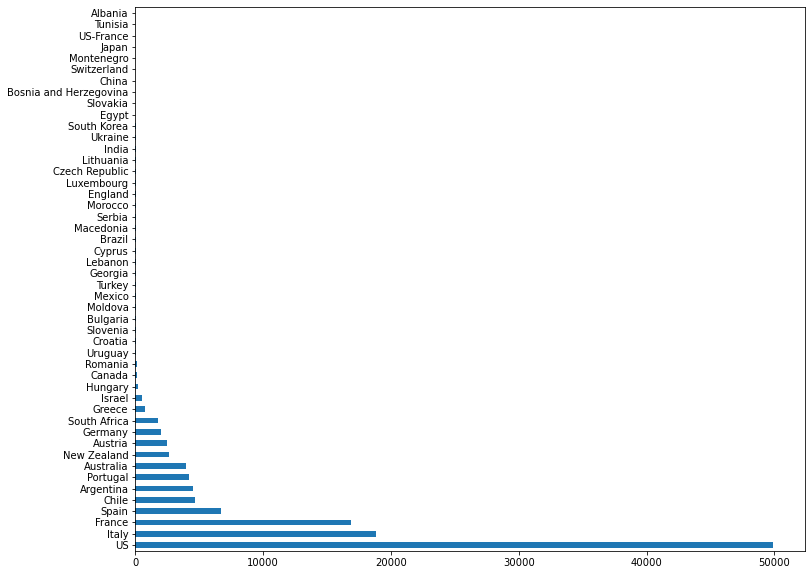

In [8]:
plt.figure(figsize= (12,10))
df_dev.country.value_counts().plot(kind= 'barh')

In [9]:
df_dev.country.value_counts()

US                        49908
Italy                     18848
France                    16835
Spain                      6657
Chile                      4647
Argentina                  4519
Portugal                   4228
Australia                  3949
New Zealand                2646
Austria                    2447
Germany                    1963
South Africa               1796
Greece                      711
Israel                      499
Hungary                     187
Canada                      153
Romania                     115
Uruguay                      81
Croatia                      72
Slovenia                     71
Bulgaria                     63
Moldova                      51
Mexico                       47
Turkey                       39
Georgia                      36
Lebanon                      31
Cyprus                       25
Brazil                       21
Macedonia                    14
Serbia                       10
Morocco                      10
England 

#### 2. province

In [10]:
df_dev.province.value_counts()

California                   35572
Washington                    7818
Tuscany                       5843
Bordeaux                      4866
Northern Spain                3930
                             ...  
Felso-Magyarország               1
Central Otago-Marlborough        1
Lemesos                          1
Slovenska Istra                  1
Casablanca-Curicó Valley         1
Name: province, Length: 444, dtype: int64

#### 3. variety

In [15]:
df_dev.variety.value_counts().nlargest(200)

Chardonnay                  11534
Pinot Noir                  11424
Cabernet Sauvignon          10270
Red Blend                    8060
Bordeaux-style Red Blend     5821
                            ...  
Colombard                      19
Vignoles                       19
Gros Manseng                   18
Cabernet                       18
Rosado                         18
Name: variety, Length: 200, dtype: int64

#### 4. winery

In [19]:
df_dev.winery.value_counts()

Williams Selyem           313
Testarossa                215
DFJ Vinhos                198
Chateau Ste. Michelle     184
Columbia Crest            174
                         ... 
Crichton Hall               1
Château des Ravatys         1
Domaine Courtois            1
Pierre Ferraud et Fils      1
Oakville Cross              1
Name: winery, Length: 14105, dtype: int64

In [52]:
top_wineries = df_dev.winery.value_counts().nlargest(1200).index

In [53]:
df_dev["norm_winery"] = [x if x in top_wineries else "others" for x in df_dev.winery]

In [41]:
df_dev.norm_winery.value_counts()

others                   71981
Williams Selyem            313
Testarossa                 215
DFJ Vinhos                 198
Chateau Ste. Michelle      184
                         ...  
Bell                        27
Clif Family                 27
Oso Libre                   27
Borra                       27
Cloudy Bay                  27
Name: norm_winery, Length: 1001, dtype: int64

#### 5. Target

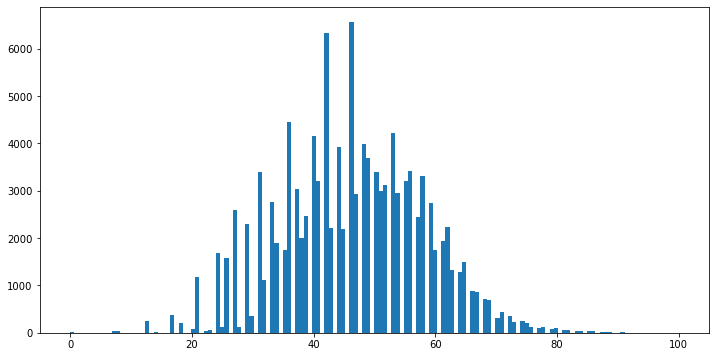

In [242]:
plt.hist(df_dev.quality, bins = 'fd');

## Feature Engineering

In [85]:
stmr = PorterStemmer()
def stemmer(line):
    clean_line = re.sub('[^a-zA-Z]'," ",line)
    words = [stmr.stem(x) for x in clean_line.lower().split()]
    
    return " ".join(words)

In [261]:
class Feature_maker:
    def __init__(self, pre_processor = None, tfidf_max_f = None):
        self.tfidf = TfidfVectorizer(stop_words='english', 
                                     preprocessor= pre_processor,
                                    norm= False, max_features= tfidf_max_f)
        self.top_words = None
        self.ohe = OneHotEncoder(handle_unknown= 'ignore')
        self.text_col = None
        self.cols = None
        
        
    def desc_encoding(self, text):
        res = self.tfidf.fit_transform(text)
        words = self.tfidf.get_feature_names()
        return words, res
    
    
    def fit_transform(self,df, text_col, cat_cols):
        self.text_col = text_col
        self.f_columns = cat_cols
        
        self.top_words, self.desc_tfidf = self.desc_encoding(df[self.text_col])
        cats_ohe = self.ohe.fit_transform(df[self.f_columns])
        
        
        return hstack((self.desc_tfidf, cats_ohe))
    
    
    def transform(self, df):
        desc_tfidf = self.tfidf.transform(df[self.text_col])
        cats_ohe = self.ohe.transform(df[self.f_columns])
        
        return hstack((desc_tfidf, cats_ohe))

In [ ]:
(96595, 31158)

In [354]:
cols = ["designation", "province","region_1","region_2","variety", "winery"]
text_col = 'description'

fmk = Feature_maker(pre_processor= None, tfidf_max_f= 500)
y = df_dev.quality.values
X = fmk.fit_transform(df_dev, text_col, cols)

In [355]:
#words_df = top_N_words(df_dev, "description", N= 150)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, shuffle = True, random_state = 999)

In [356]:
X_train.shape

(96595, 44680)

In [357]:
rid = Ridge(alpha = 0.5, tol = 0.001, random_state=999)
rid.fit(X_train, y_train)
y_hat = rid.predict(X_test)
r2_score(y_test, y_hat)

0.8292136224904365

In [324]:
# del rid
# del pca
# del model
# del params
#del search

rid = Ridge(random_state=999)

svd = TruncatedSVD(n_components= 100, n_iter= 10, random_state=999)
rfr = RandomForestRegressor(n_estimators= 40, random_state=999, n_jobs=-1)
model = make_pipeline(rid)
params = {
    "ridge__alpha": [0.1,0.5,0.8],
    "ridge__tol" : [0.01,0.001]
}
#reg = LinearRegression()
search = GridSearchCV(model, param_grid= params, cv = 3, scoring= 'r2')
search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ridge', Ridge(random_state=999))]),
             param_grid={'ridge__alpha': [0.1, 0.5, 0.8],
                         'ridge__tol': [0.01, 0.001]},
             scoring='r2')

In [331]:
search.best_params_

{'ridge__alpha': 0.5, 'ridge__tol': 0.001}

In [325]:
#model.fit(X_train, y_train)
y_hat = search.predict(X_test)
r2_score(y_test, y_hat)

0.7355367991023682

In [347]:
X_eval = fmk.transform(df_eval)

In [348]:
y_hat = rid.predict(X_eval)

In [349]:
create_results_file(y_hat)